In [1]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 # To open zipped files
import re # regular expressions
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

print(os.listdir("data"))

# https://www.kaggle.com/bittlingmayer/amazonreviews

['test.ft.txt.bz2', 'train.ft.txt.bz2']


In [2]:
train_file = bz2.BZ2File('data/train.ft.txt.bz2')
test_file = bz2.BZ2File('data/test.ft.txt.bz2')

In [3]:
# Can take some time (20'' ... 2' depending on your hardware)
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()
# save memory
del train_file, test_file
gc.collect()

42

In [4]:
len(train_file_lines), len(test_file_lines)

(3600000, 400000)

In [5]:
train_file_lines = random.sample(train_file_lines, int(0.1*len(train_file_lines))) # ONLY 10% DATA

In [6]:
test_file_lines = random.sample(test_file_lines, int(0.1*len(test_file_lines))) # ONLY 10% DATA

In [7]:
len(train_file_lines), len(test_file_lines)

(360000, 40000)

In [8]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [9]:
train_labels = np.array([0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines])
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = np.array([0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines])
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
                                                       
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [10]:
train_sentences[10], train_labels[10]

('good but not as good as the others: i love this series. i found this book to not be as good as the previous but definitely worth a read if you like the outlander series. it sets the stage for what is coming more than has an interesting story line i believe.',
 1)

In [11]:
train_sentences[8], train_labels[8]

("second pair of these sandals i've owned: i bought a pair originally while on vacation in oahu. the sandals i was wearing at the time were killing my feet, so i happened by a mall and tried these on. normally i don't pay anywhere near what i paid for these sandals, but after trying them out i decided to buy a pair. the original pair lasted almost 0 years while wearing them a few times a week. the second pair i got just in time for vacation to belize, and though i wished i hadn't got them wet and sandy, they protected my diabetic feet from harm with better than average padding.",
 1)

In [12]:
print('Training set')
print(f'{np.count_nonzero( train_labels == 0 )} in class 0')
print(f'{np.count_nonzero( train_labels == 1 )} in class 1')

Training set
180116 in class 0
179884 in class 1


c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train Labels distribution')

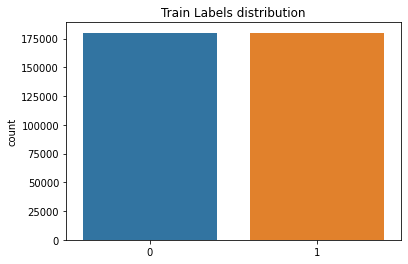

In [13]:
sns.countplot(train_labels)
plt.title('Train Labels distribution')

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Labels distribution')

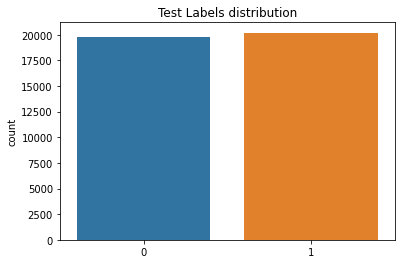

In [14]:
sns.countplot(test_labels)
plt.title('Test Labels distribution')

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

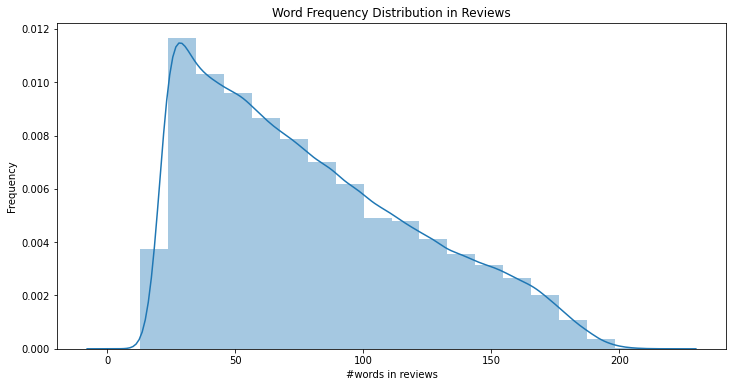

In [102]:
#Let’s count number of words in reviews and see it distribution
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))

sns.distplot(train_sentences_size, bins=20)
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

In [16]:
train_label_len = pd.DataFrame({"labels": train_labels, "len": train_sentences_size})
train_label_len

,labels,len
0,1,140
1,0,91
2,0,104
3,1,23
4,1,25
...,...,...
359995,1,84
359996,1,95
359997,1,95
359998,1,16


Negative mean length: 81.53
Positive mean length: 75.49
Mean Difference: 6.04


Text(0.5, 1.0, 'Review Size Categorization')

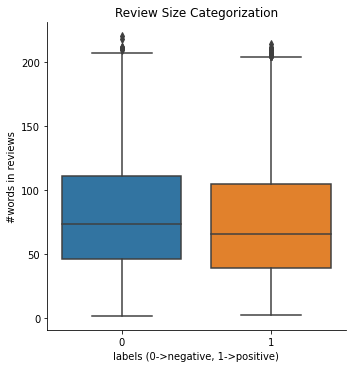

In [17]:
# Now we’ll divide it by sentiment and calculate average values

neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

In [18]:
del neg_mean_len,pos_mean_len
gc.collect()

121

In [19]:
# Clean URLs

for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [20]:
list(filter(lambda x: '<url>' in x, train_sentences))[0]

"destined to become a collector's item: this book contains the entire magickal curriculum of the hermetic order of the golden dawn as it exists today. its author david griffin, chief adept of hermetic order of the golden dawn, has been reported as saying that when this limited deluxe edition sells out soon, that there will be no further editions of this invaluable work. this means that the ritual magic manual by david griffin will soon become one of the most valuable and sought after collector's items in magickal history! the news on the street in the magickal community is that, once this limited edition sells out, its content will then become available exclusively on-line, and only to on-line members of the hermetic order of the golden dawn inside the cyber-temple at their <url> web site. i am glad that i already have my copy and would reccommend every serious student of ritual magick to get this book while they still can. this classic work is bound to become a collector's dream come 

In [21]:
del train_file_lines, test_file_lines
gc.collect()

63

In [22]:
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is WALKING walking to school')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


['he', 'be', 'walking', 'walk', 'to', 'school']

In [23]:
nltk.download('stopwords')
# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [24]:
# Clean Digits

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [25]:
train_sentences[10]

'good but not as good as the others: i love this series. i found this book to not be as good as the previous but definitely worth a read if you like the outlander series. it sets the stage for what is coming more than has an interesting story line i believe.'

In [26]:
preprocess_text(train_sentences[10])

['good',
 'good',
 'love',
 'series',
 'find',
 'book',
 'good',
 'previous',
 'worth',
 'read',
 'outlander',
 'series',
 'set',
 'stage',
 'interesting',
 'story',
 'line']

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [47]:
train_set = count_vect.fit_transform(train_sentences[:20000])

In [48]:
train_set.toarray().shape

(20000, 54250)

In [56]:
test_set = count_vect.transform(test_sentences[:2000])

<AxesSubplot:title={'center':'Most Frequent Words'}, xlabel='word'>

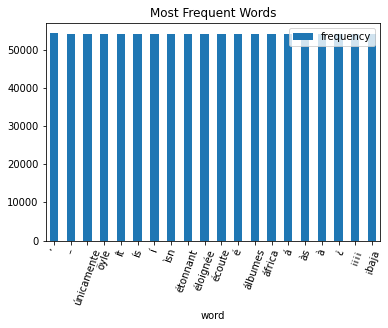

In [57]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency']).sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")

In [58]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [59]:
clf.fit(train_set, train_labels[:20000])

MultinomialNB()

In [109]:
from sklearn.metrics import accuracy_score

# To predict our tags (i.e. whether requesters get their pizza), 
# we feed the vectorized `test_set` to .predict()
accs = []
for i in range(0,10):
    
    test_set = count_vect.transform(test_sentences[i*2000:(i+1)*2000])
    predictions_valid = clf.predict(test_set)
    accs.append(accuracy_score(predictions_valid, test_labels[i*2000:(i+1)*2000]) * 100)
    print('Amazon Sentiment Analysis Accuracy = {}'.format(
            accuracy_score(predictions_valid, test_labels[i*2000:(i+1)*2000]) * 100)
         )

Amazon Sentiment Analysis Accuracy = 80.55
Amazon Sentiment Analysis Accuracy = 81.6
Amazon Sentiment Analysis Accuracy = 80.45
Amazon Sentiment Analysis Accuracy = 80.95
Amazon Sentiment Analysis Accuracy = 81.5
Amazon Sentiment Analysis Accuracy = 80.7
Amazon Sentiment Analysis Accuracy = 80.25
Amazon Sentiment Analysis Accuracy = 80.10000000000001
Amazon Sentiment Analysis Accuracy = 80.65
Amazon Sentiment Analysis Accuracy = 82.5


c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


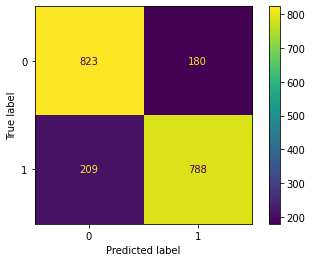

In [61]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, test_set, test_labels[:2000])

In [63]:
missclassified = predictions_valid != test_labels[:2000]

In [78]:
errors = []
for i in range(len(test_sentences[:2000])):
    if missclassified[i]:
        errors.append("True label: " + str(test_labels[i]) + " Predicted label: " + str(predictions_valid[i]) + "          " + test_sentences[i])

In [92]:
errors[14]

'True label: 1 Predicted label: 0          best bond movie ever! "you\'re joke-shop spies.": "the one & only, original, james bond." i\'ve been waiting since i first seen this on cable for the dvd and it didn\'t disappoint. i was already a 0-star fan before, but what makes this dvd great are the special features. for one i learned that peter sellers got fired for not showing up for one take that included scores of extras. i think he said he was ill. also, orson welles didn\'t like him & was loathed to work with him. despite this, it\'s interesting that sellers is credited as the star of the show. they also show the t.v. version which makes the feature seem as a work of high art.last, but not least, if one wonders about all those hot femmes as bit players, we\'re told that the studio was made in the london\'s playboy club. when one considers the bond catalog, its highs & lows, casino royale has to be near, if not the, top!'

In [93]:
%%time
#We will use a dictionary to count the number of appearences of the words :)
words = {}
for i in range(len(train_sentences)):
    for j in train_sentences[i].split():
        if j not in stoplist_combined:
            if j in words.keys():
                words[j] += 1
            else:
                words[j] = 1

Wall time: 15.1 s


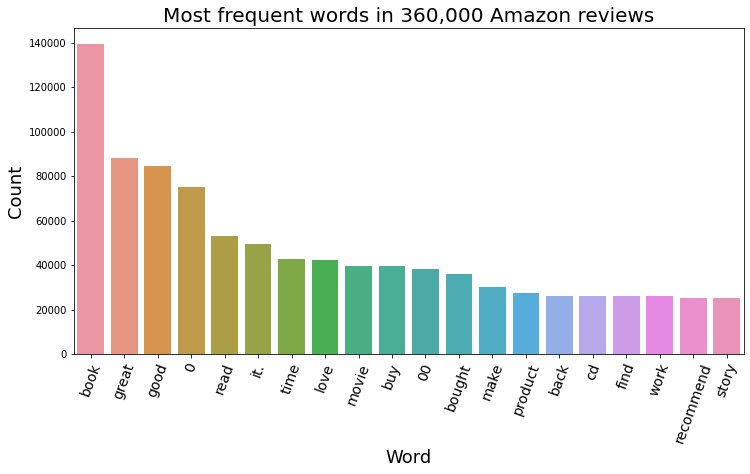

In [96]:
df_train = pd.DataFrame(list(zip(words.keys(), words.values())), columns =['Word', 'Count'])
df_train.sort_values(by="Count",ascending=False).head(30)
plt.rcParams["figure.figsize"] = (12,6)
sns.barplot(x="Word", y="Count", data=df_train.sort_values(by="Count",ascending=False).head(20))
plt.xticks(fontsize=14, rotation=70)
plt.xlabel("Word",fontsize=18)
plt.ylabel("Count", fontsize = 18)
plt.title("Most frequent words in 360,000 Amazon reviews", fontsize=20);

In [112]:
import statistics
sd = statistics.stdev(accs)
m = statistics.mean(accs)
print("Amazon Sentiment Analysis Accuracy: ", m, "+-", round(sd,3))

Amazon Sentiment Analysis Accuracy:  80.925 +- 0.738
